In [44]:
# !pip install bayesian-optimization

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.base import clone
np.random.seed(22)
random.seed(22)

In [3]:
train = pd.read_parquet('../Data/Processed/df_clean_train.parquet')
test = pd.read_parquet('../Data/Processed/df_clean_test.parquet')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27613 entries, 28705 to 23938
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   year                          27613 non-null  int64         
 1   month                         27613 non-null  int64         
 2   region                        27613 non-null  object        
 3   district                      27613 non-null  object        
 4   site_code                     27613 non-null  object        
 5   product_code                  27613 non-null  object        
 6   stock_initial                 27613 non-null  int64         
 7   stock_received                27613 non-null  int64         
 8   stock_distributed             27613 non-null  int64         
 9   stock_adjustment              27613 non-null  int64         
 10  stock_end                     27613 non-null  int64         
 11  average_monthly_consumpt

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 816 to 3885
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   year                          8140 non-null   int64         
 1   month                         8140 non-null   int64         
 2   region                        8140 non-null   object        
 3   district                      8140 non-null   object        
 4   site_code                     8140 non-null   object        
 5   product_code                  8140 non-null   object        
 6   stock_initial                 8140 non-null   int64         
 7   stock_received                8140 non-null   int64         
 8   stock_distributed             8140 non-null   int64         
 9   stock_adjustment              8140 non-null   int64         
 10  stock_end                     8140 non-null   int64         
 11  average_monthly_consumption 

In [6]:
test.product_site_interaction.value_counts()

AS27138_C5066    8
AS27138_C2061    8
AS27132_C2062    8
AS27133_C2062    8
AS27134_C2062    8
                ..
AS21126_C2055    1
AS21126_C3010    1
AS27139_C2069    1
AS21126_C2131    1
AS21126_C2016    1
Name: product_site_interaction, Length: 1132, dtype: int64

In [13]:
df_train = train.drop(['year','date','site_code','product_site_interaction'], axis=1)
df_test = test.drop(['year','date','site_code','product_site_interaction'], axis=1)

target_col = 'stock_distributed'
categorical_cols = [col for col in df_train.columns if train[col].dtype == 'object']
numerical_cols = [col for col in df_test.columns if col not in categorical_cols + [target_col]]

# Data preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Splitting the data into training and testing sets (date split)
X_train = df_train.drop(columns=[target_col])
y_train = df_train.stock_distributed
X_test = df_test.drop(columns=[target_col])
y_test = df_test.stock_distributed

# Applying the preprocessor to the feature sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Check if the transformed data is in a sparse matrix format
if isinstance(X_train_transformed, np.ndarray):
    print("Transformed data is a NumPy array.")
else:
    print("Transformed data is a sparse matrix. Converting to NumPy array.")
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()

# Get feature names for one-hot encoded columns
onehot_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine all feature names
all_columns = numerical_cols + list(onehot_columns)

# Check the shape of transformed data and number of column names
print("Shape of X_train_transformed:", X_train_transformed.shape)
print("Number of combined columns:", len(all_columns))

# Ensure that the number of columns in all_columns matches the number of columns in X_train_transformed

# Converting transformed training data back to DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_columns, index=X_train.index)

# Converting transformed test data back to DataFrame
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_columns, index=X_test.index)


Transformed data is a sparse matrix. Converting to NumPy array.
Shape of X_train_transformed: (27613, 141)
Number of combined columns: 141


In [14]:
print(f'X_train_transformed_df.shape: {X_train_transformed_df.shape}')
print(f'X_test_transformed_df.shape: {X_test_transformed_df.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train_transformed_df.shape: (27613, 141)
X_test_transformed_df.shape: (8140, 141)
y_train.shape: (27613,)
y_test.shape: (8140,)


In [30]:
df_combined = pd.concat([X_train_transformed_df, X_test_transformed_df])
vif_data = pd.DataFrame()
vif_data['Feature'] = df_combined.columns

# Add a constant column for the intercept in the model
df_with_constant = add_constant(df_combined)

# Calculate VIF for each feature
vif_data['Feature'] = df_with_constant.columns[1:]  # Exclude the constant column for VIF calculation
vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) for i in range(1, df_with_constant.shape[1])]

# Set a threshold for VIF, above which a feature is considered multicollinear
vif_threshold = 5  # This is a commonly used threshold value

# Identify features that have a high VIF
features_with_high_vif = vif_data[vif_data['VIF'] > vif_threshold]['Feature'].tolist()

# Drop features with high VIF from the dataframe
df_reduced = df_combined.drop(columns=features_with_high_vif)

# The df_reduced dataframe now has reduced multicollinearity
df_reduced.head()

C:\Users\andil\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,stock_ordered,stock_ordered_imputed_flag,stock_to_demand_ratio,high_demand_season,low_demand_season,rate_change_stock_dist,stock_sufficiency,std_dev_6m_stock_dist,consumption_rate,trendline_stock_distributed,stockout,stock_utilization,consumption_growth_rate
28705,0.030347,-0.16163,-0.191907,1.642259,-0.570367,-0.073546,0.425621,-0.300003,-0.128418,1.413549,-0.240684,-0.115492,0.751396
18487,0.123212,-0.16163,-0.191907,1.642259,-0.570367,-0.073546,0.425621,-0.456487,-0.128418,-1.048645,-0.240684,-0.115492,0.751396
18490,0.123212,-0.16163,-0.258369,1.642259,-0.570367,-0.073546,0.425621,-0.301576,0.535459,-1.055654,-0.240684,-0.000644,0.751396
18496,-0.043945,-0.16163,-0.260715,-0.608917,-0.570367,1.453407,0.425621,0.352020,0.393199,-1.062315,-0.240684,-0.048914,0.751396
18499,0.188217,-0.16163,-0.310906,-0.608917,-0.570367,-0.277077,-2.349508,0.243714,-0.087321,-1.068626,-0.240684,0.399882,-0.131207


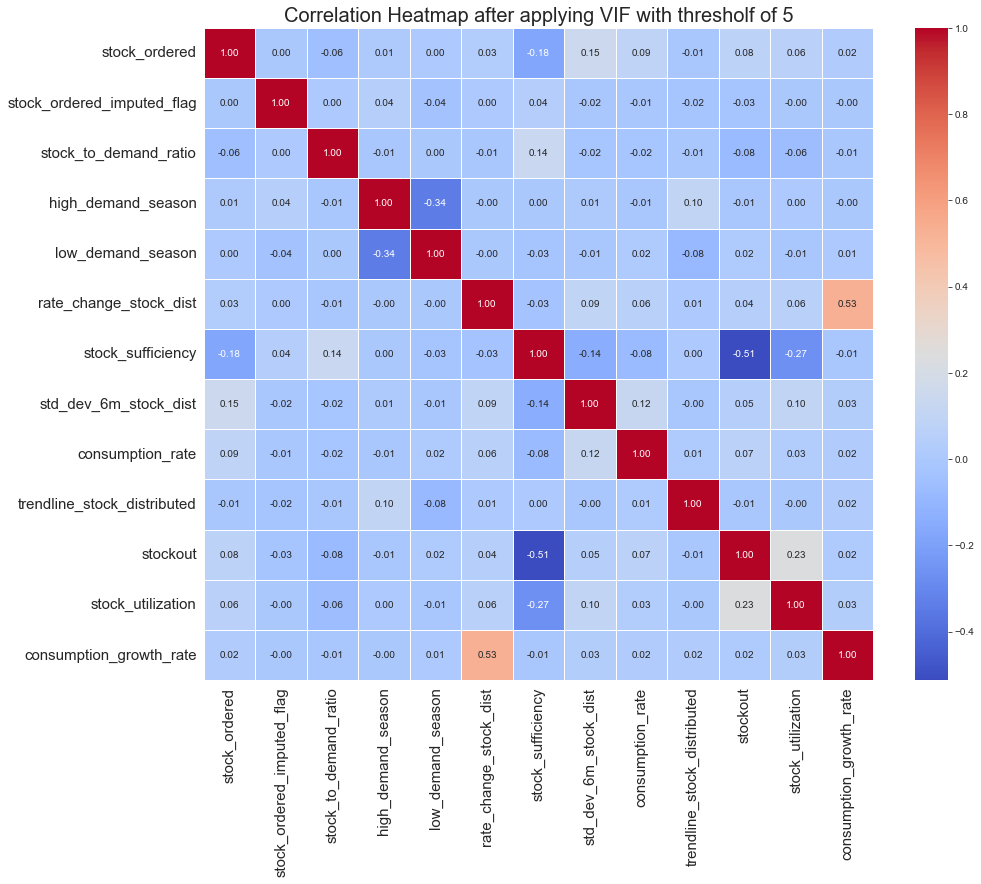

In [52]:

plt.figure(figsize=(15, 12))
sns.heatmap(pd.concat([X_train_transformed_df[df_reduced.columns], X_test_transformed_df[df_reduced.columns]]).corr(), 
            cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap after applying VIF with thresholf of 5", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

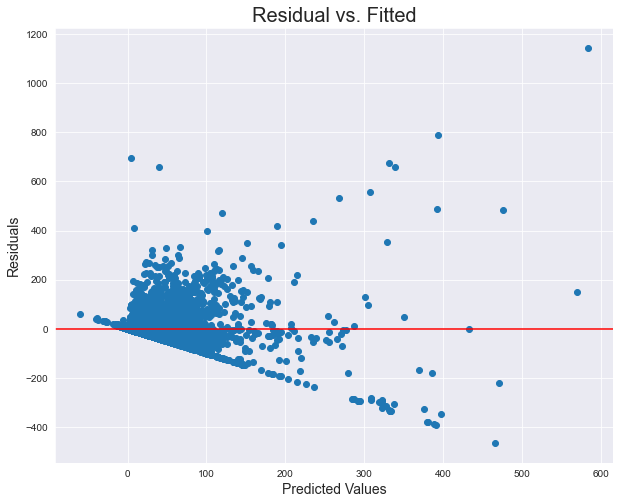

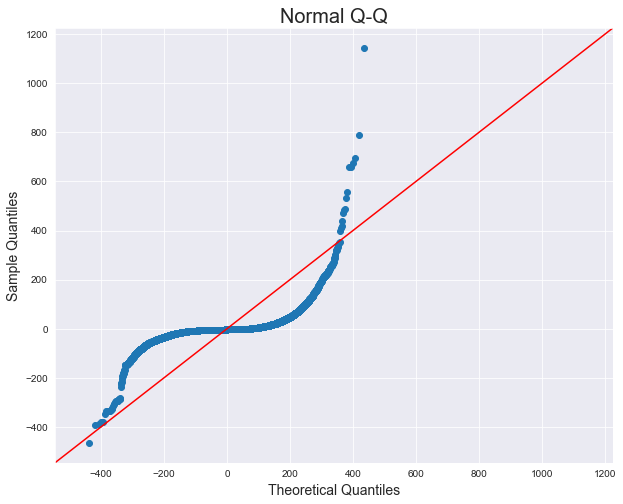

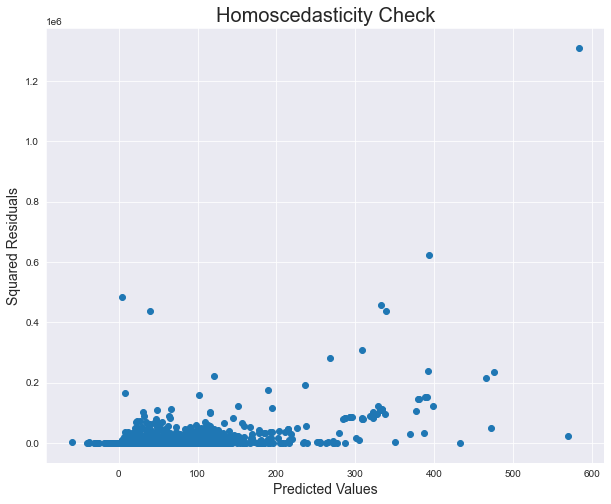

Durbin-Watson: 1.2299709444622287


In [64]:

# Fitting the model
model = sm.OLS(y_train, sm.add_constant(X_train_transformed_df[df_reduced.columns])).fit()

# Predictions
predictions = model.predict(sm.add_constant(X_train_transformed_df[df_reduced.columns]))

# Residuals
residuals = y_train - predictions

# Checking for Linearity
plt.figure(figsize=(10, 8))
plt.scatter(predictions, residuals)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual vs. Fitted', fontsize=20)
plt.show()

# Checking for Normality of Residuals
fig = plt.figure(figsize=(10, 8)) 
ax = fig.add_subplot(111) 
fig = sm.qqplot(residuals, line='45', ax=ax, scale=110)  
ax.set_title('Normal Q-Q', fontsize=20)  
ax.set_xlabel('Theoretical Quantiles', fontsize=14)  
ax.set_ylabel('Sample Quantiles', fontsize=14) 
plt.show() 


# Checking for Homoscedasticity
plt.figure(figsize=(10, 8))
plt.scatter(predictions, residuals ** 2)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Squared Residuals', fontsize=14)
plt.title('Homoscedasticity Check', fontsize=20)
plt.show()

# Checking for Independence of residuals
durbin_watson = sm.stats.stattools.durbin_watson(residuals)
print('Durbin-Watson:', durbin_watson)


In [39]:
# # Starting with Linear regression
# # Creating the linear regression model
# 
# pipeline = Pipeline(steps=[('classifier', LinearRegression())])
# # Train model
# pipeline.fit(X_train_transformed_df[df_reduced.columns], y_train)
# 
# # Fitting the model
# pipeline.fit(X_train_transformed_df[df_reduced.columns], y_train)
# 
# # Getting the predictions on the test set
# y_pred_train = pipeline.predict(X_train_transformed_df[df_reduced.columns])
# y_pred_test = pipeline.predict(X_test_transformed_df[df_reduced.columns])
# 
# # Compute metrics
# mse_train = mean_squared_error(y_train, y_pred_train)
# mse_test = mean_squared_error(y_test, y_pred_test)
# 
# print('MSE train: ',mse_train)
# print('MSE test: ',mse_test)
# 
# # Calculating the residuals on the test set
# residuals = y_test - y_pred_test
# 
# # Creating the Residual vs. Fitted plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(y_pred_test, residuals)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.title('Residual vs. Fitted')
# plt.xlabel('Fitted Values')
# plt.ylabel('Residuals')
# 
# # Show the plot
# plt.show()

In [40]:


# Define the hyperparameter space for each model
param_spaces = {
    'Decision Tree Regressor': {
        'max_depth': (1, 32),
        'min_samples_split': (2, 100)
    },
    'Random Forests Regressor': {
        'n_estimators': (10, 300),
        'max_depth': (1, 32)
    },
    'Gradient Boosting Regressor': {
        'n_estimators': (10, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (1, 32)
    }
}

# Function to optimize each model using Bayesian optimization
def optimize_model(model, params, X_train, y_train):
    # Define the scoring function for Bayesian optimization
    def model_cv_score(**hyperparams):
        # Round the integer parameters
        if 'max_depth' in hyperparams:
            hyperparams['max_depth'] = int(hyperparams['max_depth'])
        if 'min_samples_split' in hyperparams:
            hyperparams['min_samples_split'] = int(hyperparams['min_samples_split'])
        if 'n_estimators' in hyperparams:
            hyperparams['n_estimators'] = int(hyperparams['n_estimators'])

        model_clone = clone(model)
        model_clone.set_params(**hyperparams)
        kf = KFold(n_splits=5, shuffle=True, random_state=22)
        scores = cross_val_score(model_clone, X_train_transformed_df, y_train, cv=kf, scoring='neg_mean_squared_error')
        return np.mean(scores)

    # Define the optimization
    optimizer = BayesianOptimization(f=model_cv_score, pbounds=params, random_state=1)
    optimizer.maximize(n_iter=25, init_points=5)

    return optimizer.max['params']

models = [
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('Random Forests Regressor', RandomForestRegressor()),
    ('Gradient Boosting Regressor', GradientBoostingRegressor())
]

tuned_results = []

for name, model in models:
    print(f'Tuning {name}')
    best_params = optimize_model(model, param_spaces[name], X_train, y_train)
    # Make sure to convert to int for those hyperparameters that require it
    best_params['max_depth'] = int(best_params['max_depth'])
    if 'min_samples_split' in best_params:
        best_params['min_samples_split'] = int(best_params['min_samples_split'])
    if 'n_estimators' in best_params:
        best_params['n_estimators'] = int(best_params['n_estimators'])
    model.set_params(**best_params)
    model.fit(X_train_transformed_df, y_train)

    train_predictions = model.predict(X_train_transformed_df)
    test_predictions = model.predict(X_test_transformed_df)

    mse_train = mean_squared_error(y_train, train_predictions)
    mse_test = mean_squared_error(y_test, test_predictions)

    r2_train = r2_score(y_train, train_predictions)
    r2_test = r2_score(y_test, test_predictions)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    tuned_results.append((name, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test))

tuned_results_df = pd.DataFrame(tuned_results, columns=['Model', 'Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE', 'Train R-Squared', 'Test R-Squared'])


In [47]:
def adjusted_r_squared(r_squared, num_obs, num_predictors):
    return 1 - (1 - r_squared) * (num_obs - 1) / (num_obs - num_predictors - 1)

num_obs_train = X_train.shape[0]  # Number of observations in the training set
num_obs_test = X_test.shape[0]    # Number of observations in the testing set
num_predictors = X_train.shape[1]  # Number of predictors

In [48]:
# Without grid search
# Redefining the list of models
models = [
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('Random Forests Regressor', RandomForestRegressor()),
    ('Gradient Boosting Regressor', GradientBoostingRegressor())
]

results = []

# Iterate over models, train, predict, and compute metrics
for name, classifier in models:
    
    print(f'Running {name} model')
    # Create pipeline for the current model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])
    # Train model
    pipeline.fit(X_train, y_train)

    # Predict
    train_predictions = pipeline.predict(X_train)
    test_predictions = pipeline.predict(X_test)

    # Compute metrics
    mse_train = mean_squared_error(y_train, train_predictions)
    mse_test = mean_squared_error(y_test, test_predictions)

    r2_train = r2_score(y_train, train_predictions)
    r2_test = r2_score(y_test, test_predictions)

    # Calculate Adjusted R-squared for the training set
    adj_r2_train = adjusted_r_squared(r2_train, num_obs_train, num_predictors)
    # Calculate Adjusted R-squared for the testing set
    adj_r2_test = adjusted_r_squared(r2_test, num_obs_test, num_predictors)

    rmse_train = mean_squared_error(y_train, train_predictions, squared=False)
    rmse_test = mean_squared_error(y_test, test_predictions, squared=False)
    
    results.append((name, mse_train, mse_test, rmse_train, rmse_test, adj_r2_train, adj_r2_test))

    # Save the trained model using joblib
    dump(pipeline, f'Models/{name.replace(" ", "_")}_model.joblib')

# Convert results to DataFrame for display
results_df = pd.DataFrame(results, columns=['Model', 'Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE', 'Train Adjusted R-Squared', 'Test Adjusted R-Squared'])


Running Decision Tree Regressor model
Running Random Forests Regressor model
Running Gradient Boosting Regressor model


In [50]:
results_df.drop(columns=['Train MSE', 'Test MSE'])

,Model,Train RMSE,Test RMSE,Train Adjusted R-Squared,Test Adjusted R-Squared
0,Decision Tree Regressor,0.000000,7.829949,1.000000,0.955356
1,Random Forests Regressor,3.052215,5.963237,0.994346,0.974105
2,Gradient Boosting Regressor,3.838729,6.381642,0.991056,0.970344


In [68]:
hyperparam_results = []

MSE train: 57.6254356023189	 Adjusted R_squared train: 0.9650245572177326	 RMSE train: 7.591141916887004
MSE test: 67.74876648086465	 Adjusted R_squared test: 0.9506661561613132	 RMSE test: 8.230963885284922


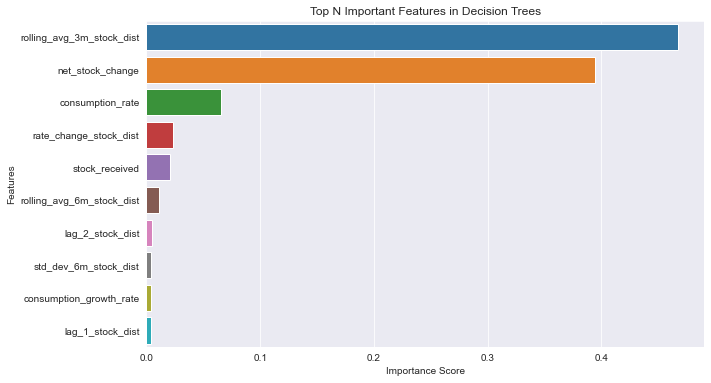

In [69]:
# Train a Decision Tree Regressor model with hyperparameters 
name = 'Decision Tree Regressor'
tree = DecisionTreeRegressor(min_samples_split=25, max_depth=17, random_state=22)
tree.fit(X_train_transformed_df, y_train)

train_predictions = tree.predict(X_train_transformed_df)
test_predictions = tree.predict(X_test_transformed_df)

# Compute metrics
mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)

r2_train = r2_score(y_train, train_predictions)
r2_test = r2_score(y_test, test_predictions)

# Calculate Adjusted R-squared for the training set
adj_r2_train = adjusted_r_squared(r2_train, num_obs_train, num_predictors)
# Calculate Adjusted R-squared for the testing set
adj_r2_test = adjusted_r_squared(r2_test, num_obs_test, num_predictors)

rmse_train = mean_squared_error(y_train, train_predictions, squared=False)
rmse_test = mean_squared_error(y_test, test_predictions, squared=False)

hyperparam_results.append((name, mse_train, mse_test, rmse_train, rmse_test, adj_r2_train, adj_r2_test))

print(f'MSE train: {mse_train}\t Adjusted R_squared train: {adj_r2_train}\t RMSE train: {rmse_train}')
print(f'MSE test: {mse_test}\t Adjusted R_squared test: {adj_r2_test}\t RMSE test: {rmse_test}')

# # Get feature importances
importances = tree.feature_importances_

# Convert to a Series for easy manipulation
importances_series = pd.Series(importances, index=X_train_transformed_df.columns)

# Sort the feature importances
sorted_importances = importances_series.sort_values(ascending=False)

# Select the top n features
n = 10  # Change this value based on your need
top_n_importances = sorted_importances[:n]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_n_importances, y=top_n_importances.index)
plt.title('Top N Important Features in Decision Trees')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

MSE train: 155.04002309922672	 Adjusted R_squared train: 0.9058993064401198	 RMSE train: 12.45150686058626
MSE test: 86.20740277654484	 Adjusted R_squared test: 0.9372247973323904	 RMSE test: 9.284794169853463


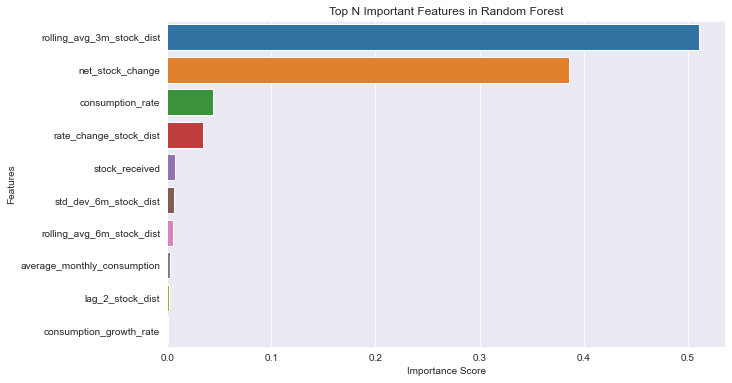

In [70]:
# Train a Decision Tree Regressor model with hyperparameters 
name = 'Random Forest Regressor'
rf = RandomForestRegressor(min_samples_split=237, max_depth=16, random_state=22)
rf.fit(X_train_transformed_df, y_train)

train_predictions = rf.predict(X_train_transformed_df)
test_predictions = rf.predict(X_test_transformed_df)

# Compute metrics
mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)

r2_train = r2_score(y_train, train_predictions)
r2_test = r2_score(y_test, test_predictions)

# Calculate Adjusted R-squared for the training set
adj_r2_train = adjusted_r_squared(r2_train, num_obs_train, num_predictors)
# Calculate Adjusted R-squared for the testing set
adj_r2_test = adjusted_r_squared(r2_test, num_obs_test, num_predictors)

rmse_train = mean_squared_error(y_train, train_predictions, squared=False)
rmse_test = mean_squared_error(y_test, test_predictions, squared=False)

hyperparam_results.append((name, mse_train, mse_test, rmse_train, rmse_test, adj_r2_train, adj_r2_test))

print(f'MSE train: {mse_train}\t Adjusted R_squared train: {adj_r2_train}\t RMSE train: {rmse_train}')
print(f'MSE test: {mse_test}\t Adjusted R_squared test: {adj_r2_test}\t RMSE test: {rmse_test}')

# # Get feature importances
importances = rf.feature_importances_

# Convert to a Series for easy manipulation
importances_series = pd.Series(importances, index=X_train_transformed_df.columns)

# Sort the feature importances
sorted_importances = importances_series.sort_values(ascending=False)

# Select the top n features
n = 10  # Change this value based on your need
top_n_importances = sorted_importances[:n]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_n_importances, y=top_n_importances.index)
plt.title('Top N Important Features in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

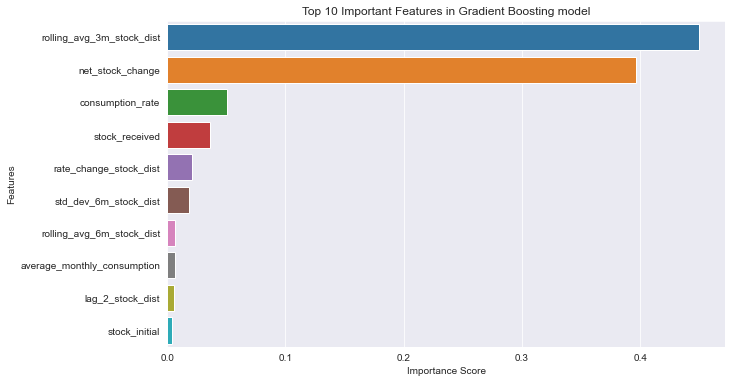

In [75]:
# Train a Gradient Boosting Regressor model with hyperparameters 
name = 'Gradient Boosting Regressor'
gb = GradientBoostingRegressor(min_samples_split=208, max_depth=3, learning_rate=0.3, random_state=22)
gb.fit(X_train_transformed_df, y_train)

train_predictions = gb.predict(X_train_transformed_df)
test_predictions = gb.predict(X_test_transformed_df)

# Compute metrics
mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)

r2_train = r2_score(y_train, train_predictions)
r2_test = r2_score(y_test, test_predictions)

# Calculate Adjusted R-squared for the training set
adj_r2_train = adjusted_r_squared(r2_train, num_obs_train, num_predictors)
# Calculate Adjusted R-squared for the testing set
adj_r2_test = adjusted_r_squared(r2_test, num_obs_test, num_predictors)

rmse_train = mean_squared_error(y_train, train_predictions, squared=False)
rmse_test = mean_squared_error(y_test, test_predictions, squared=False)

hyperparam_results.append((name, mse_train, mse_test, rmse_train, rmse_test, adj_r2_train, adj_r2_test))

print(f'MSE train: {mse_train}\t Adjusted R_squared train: {adj_r2_train}\t RMSE train: {rmse_train}')
print(f'MSE test: {mse_test}\t Adjusted R_squared test: {adj_r2_test}\t RMSE test: {rmse_test}')

# # Get feature importances
importances = gb.feature_importances_

# Convert to a Series for easy manipulation
importances_series = pd.Series(importances, index=X_train_transformed_df.columns)

# Sort the feature importances
sorted_importances = importances_series.sort_values(ascending=False)

# Select the top n features
n = 10  # Change this value based on your need
top_n_importances = sorted_importances[:n]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_n_importances, y=top_n_importances.index)
plt.title(f'Top {n} Important Features in Gradient Boosting model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [72]:

hyper_results_df = pd.DataFrame(hyperparam_results, columns=['Model', 'Train MSE', 'Test MSE', 'Train RMSE', 'Test RMSE', 'Train Adjusted R-Squared', 'Test Adjusted R-Squared'])
hyper_results_df.drop(columns=['Train MSE', 'Test MSE'])

,Model,Train RMSE,Test RMSE,Train Adjusted R-Squared,Test Adjusted R-Squared
0,Decision Tree Regressor,7.591142,8.230964,0.965025,0.950666
1,Random Forest Regressor,12.451507,9.284794,0.905899,0.937225
2,Gradient Boosting Regressor,3.333991,5.224082,0.993254,0.980127


In [73]:
results_df.drop(columns=['Train MSE', 'Test MSE'])

,Model,Train RMSE,Test RMSE,Train Adjusted R-Squared,Test Adjusted R-Squared
0,Decision Tree Regressor,0.000000,7.829949,1.000000,0.955356
1,Random Forests Regressor,3.052215,5.963237,0.994346,0.974105
2,Gradient Boosting Regressor,3.838729,6.381642,0.991056,0.970344


In [74]:
X_train_transformed_df.shape

(27613, 141)